# Develop Validation Metrics

In this notebook I'm developing a class to evaluate the source finding algorithms. The main metrics use here are completeness and contamination.


In [43]:
import numpy as np

import glob

from astropy.table import Table, join, vstack
from astropy.io import fits

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm


In [79]:
%matplotlib inline


In [570]:
fnames = glob.glob('data/gaia_matched_*')
fnames[:5]

['data/gaia_matched_2020031400335.fits',
 'data/gaia_matched_2020021900327.fits',
 'data/gaia_matched_2021011900192.fits',
 'data/gaia_matched_2020031500242.fits',
 'data/gaia_matched_2020031500155.fits']

In [571]:
def get_expid(fname):
    return int(fname.split('.fits')[0][-13:])


In [572]:
tables = []
new_expIds = []
for i,fname in enumerate(fnames):
    # print(f'{i}: {fname}')
    tables.append(Table(fits.getdata(fname)))
    new_expIds.append(get_expid(fname))

In [573]:
# table = vstack(tables)
# good = (table['base_CircularApertureFlux_3_0_instFlux']/table['base_CircularApertureFlux_3_0_instFluxErr'] > 50) | np.isnan(table['base_CircularApertureFlux_3_0_instFlux'])
# table = table[good]

In [592]:
## table.write('gaia_matched_feb2022.fits',format='fits')
table = Table(fits.getdata('gaia_matched_feb2022.fits'))

In [593]:
## Define all masks

gaia = np.isfinite(table['ref_ra'])
auxtel = np.isfinite(table['base_SdssCentroid_x'])
only_gaia = np.isnan(table['base_CircularApertureFlux_3_0_instFlux'])
only_auxtel = (np.isnan(table['ref_ra']))
matched = table['id_match']>0.
good = (table['base_CircularApertureFlux_3_0_instFlux']/table['base_CircularApertureFlux_3_0_instFluxErr'] > 5.) | only_gaia


In [594]:
table[auxtel&good]

base_SdssCentroid_x,base_SdssCentroid_y,base_CircularApertureFlux_3_0_instFlux,base_CircularApertureFlux_3_0_instFluxErr,ra,dec,gaia,id_match,source_id,ref_ra,ref_dec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,radius_val,ref_base_SdssCentroid_x,ref_base_SdssCentroid_y,dist,auxtel,DATE,FILTER,EXPTIME,X0,Y0
float64,float64,float64,float64,float64,float64,bool,int64,int64,float64,float64,float32,float32,float32,float32,float64,float64,int64,bool,str23,str5,float64,float64,float64
1995.0613557980203,2503.559792022554,296554.625,516.419677734375,221.78838703982447,-44.850722758325304,True,-2,999999,nan,nan,nan,nan,nan,nan,nan,nan,999999,True,2022-02-18T07:30:18.294,SDSSg,30.0,2088.0000000000005,2005.9999999999998
1664.6184559192932,1193.8199508516211,648.0979614257812,62.297882080078125,221.77662915658556,-44.885649929237076,True,-2,999999,nan,nan,nan,nan,nan,nan,nan,nan,999999,True,2022-02-18T07:30:18.294,SDSSg,30.0,2088.0000000000005,2005.9999999999998
3278.7962432653117,3659.03833507335,4079.4228515625,75.90696716308594,221.8359314362207,-44.81955910433138,True,-2,999999,nan,nan,nan,nan,nan,nan,nan,nan,999999,True,2022-02-18T07:30:18.294,SDSSg,30.0,2088.0000000000005,2005.9999999999998
1876.7936115248044,3973.8964111486443,4070.218017578125,82.89256286621094,221.78323829742504,-44.811679686255644,True,-2,999999,nan,nan,nan,nan,nan,nan,nan,nan,999999,True,2022-02-18T07:30:18.294,SDSSg,30.0,2088.0000000000005,2005.9999999999998
818.03926446838,32.46064559887377,651.3306884765625,69.36338806152344,221.74541104728178,-44.91680285504987,False,-2,999999,nan,nan,nan,nan,nan,nan,nan,nan,999999,True,2022-02-18T07:30:18.294,SDSSg,30.0,2088.0000000000005,2005.9999999999998
3346.283858002237,1601.8568017188068,4004.751708984375,81.98274230957031,221.8395127034799,-44.8742170248956,True,-2,999999,nan,nan,nan,nan,nan,nan,nan,nan,999999,True,2022-02-18T07:30:18.294,SDSSg,30.0,2088.0000000000005,2005.9999999999998
1177.7243902286343,2803.0205790457703,665.8470458984375,62.91731262207031,221.7575985833925,-44.84303849045605,False,-2,999999,nan,nan,nan,nan,nan,nan,nan,nan,999999,True,2022-02-18T07:30:18.294,SDSSg,30.0,2088.0000000000005,2005.9999999999998
637.6323410523704,1888.8618981951706,3991.41943359375,86.56644439697266,221.73777498444886,-44.86751595984922,True,-2,999999,nan,nan,nan,nan,nan,nan,nan,nan,999999,True,2022-02-18T07:30:18.294,SDSSg,30.0,2088.0000000000005,2005.9999999999998
780.5392926465483,2475.263979416738,671.3843383789062,61.19914245605469,221.74286093396537,-44.851881813555856,True,-2,999999,nan,nan,nan,nan,nan,nan,nan,nan,999999,True,2022-02-18T07:30:18.294,SDSSg,30.0,2088.0000000000005,2005.9999999999998


In [595]:
table[good][:5]

base_SdssCentroid_x,base_SdssCentroid_y,base_CircularApertureFlux_3_0_instFlux,base_CircularApertureFlux_3_0_instFluxErr,ra,dec,gaia,id_match,source_id,ref_ra,ref_dec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,radius_val,ref_base_SdssCentroid_x,ref_base_SdssCentroid_y,dist,auxtel,DATE,FILTER,EXPTIME,X0,Y0
float64,float64,float64,float64,float64,float64,bool,int64,int64,float64,float64,float32,float32,float32,float32,float64,float64,int64,bool,str23,str5,float64,float64,float64
1995.0613557980203,2503.559792022554,296554.625,516.419677734375,221.78838703982447,-44.850722758325304,True,-2,999999,nan,nan,nan,nan,nan,nan,nan,nan,999999,True,2022-02-18T07:30:18.294,SDSSg,30.0,2088.0000000000005,2005.9999999999998
1664.6184559192932,1193.8199508516211,648.0979614257812,62.297882080078125,221.77662915658556,-44.885649929237076,True,-2,999999,nan,nan,nan,nan,nan,nan,nan,nan,999999,True,2022-02-18T07:30:18.294,SDSSg,30.0,2088.0000000000005,2005.9999999999998
3278.7962432653117,3659.03833507335,4079.4228515625,75.90696716308594,221.8359314362207,-44.81955910433138,True,-2,999999,nan,nan,nan,nan,nan,nan,nan,nan,999999,True,2022-02-18T07:30:18.294,SDSSg,30.0,2088.0000000000005,2005.9999999999998
1876.7936115248044,3973.8964111486443,4070.218017578125,82.89256286621094,221.78323829742504,-44.811679686255644,True,-2,999999,nan,nan,nan,nan,nan,nan,nan,nan,999999,True,2022-02-18T07:30:18.294,SDSSg,30.0,2088.0000000000005,2005.9999999999998
818.03926446838,32.46064559887377,651.3306884765625,69.36338806152344,221.74541104728178,-44.91680285504987,False,-2,999999,nan,nan,nan,nan,nan,nan,nan,nan,999999,True,2022-02-18T07:30:18.294,SDSSg,30.0,2088.0000000000005,2005.9999999999998


In [596]:
from scipy.stats import gaussian_kde
def compute_kde(x,bw=None):
    Norm = len(x)
    pdf = gaussian_kde(x, bw_method=bw)
    return pdf, Norm

def compute_fraction_kde(xvec, x, mask, bw=None,eps=1e-3):
    pdf1, N1 = compute_kde(x, bw=bw)
    if bw is None: bw = pdf1.scotts_factor()
    pdf2, N2 = compute_kde(x[mask], bw=bw)
    denumerator = N1*pdf1(xvec)
    frac = N2*pdf2(xvec)/denumerator
    return frac

def compute_fraction_err(mvec, mag, mask, bw=0.01, nBootStrap=100, error=True):
    nsize = len(mvec)
    frac = np.full((nsize, nBootStrap), np.nan)
    if error:
        for i in range(nBootStrap):
            idx = sample_vec(mag) # similar to: df.sample(frac=1, replace=True)
            frac[:,i] = compute_fraction_kde(mvec, mag[idx], mask[idx], bw=bw)
    else:
        fr = compute_fraction_kde(mvec, mag, mask, bw=bw)
        for i in range(nBootStrap):
            frac[:,i] = fr
    return frac

def sample_vec(x):
    idx = np.random.randint(0,x.size,size=x.size,dtype=int)
    return idx

def plot_curve(x, y, percentiles=[16,84],ax=None,color=None,**args):
    if ax is None: ax = plt.axes()
    
    ylow = np.percentile(y,percentiles[0],axis=1)
    yhig = np.percentile(y,percentiles[1],axis=1)
    ymean = np.median(y,axis=1)
    
    p = ax.plot(x,ymean,color=color,**args)
    ax.fill_between(x,ylow,yhig,color=p[0].get_color(),alpha=0.3)
    
    #ax.scatter(x,ymean, s=1,color=color,**args)

In [597]:
mag = np.array(table['phot_g_mean_mag'])

flux = np.array(table['base_CircularApertureFlux_3_0_instFlux'])
log_flux = np.log10(flux)

flux[np.isnan(flux)] = -1.
log_flux[np.isnan(log_flux)] = -1.

/tmp/ipykernel_14792/686420702.py:4: RuntimeWarning: invalid value encountered in log10
  log_flux = np.log10(flux)


In [598]:
np.min(log_flux[auxtel])

-2.1644191208291086

In [599]:
snr = table['base_CircularApertureFlux_3_0_instFlux']/table['base_CircularApertureFlux_3_0_instFluxErr']

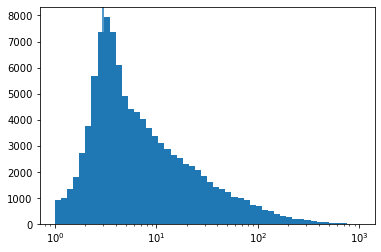

In [600]:
plt.hist(snr,bins=np.logspace(0.,3,51))
plt.axvline(3.)
plt.xscale('log')

In [603]:
mag_0 = 10.
mvec = np.arange(mag_0,18.+0.05,0.05)
m_frac = compute_fraction_err(mvec, mag[gaia], matched[gaia], bw=0.05, nBootStrap=100, error=True)

In [604]:
m_frac_mask = compute_fraction_err(mvec, mag[gaia&good], (matched)[gaia&good], bw=0.05, nBootStrap=200, error=True)


Text(0.5, 1.0, 'Gaia Sources')

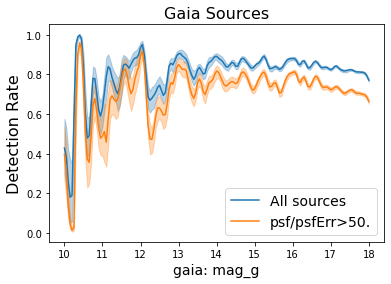

In [605]:
plot_curve(mvec ,m_frac, label='All sources',ax=plt)
plot_curve(mvec ,m_frac_mask, label='psf/psfErr>50.',ax=plt)
plt.legend(fontsize=14)
plt.xlabel('gaia: mag_g',fontsize=14)
plt.ylabel('Detection Rate',fontsize=16)
plt.title('Gaia Sources',fontsize=16)

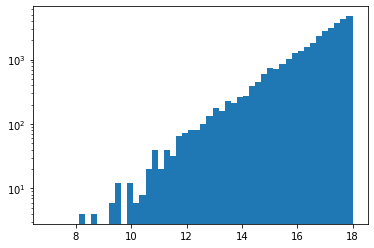

In [606]:
plt.hist(mag[gaia],bins=np.linspace(7,18,51))
plt.yscale('log')

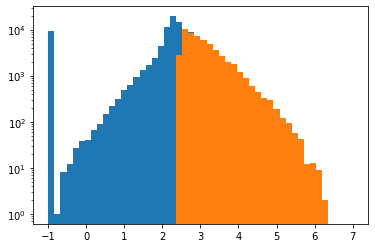

In [607]:
plt.hist(log_flux[auxtel],bins=np.linspace(-1,7.,51))
plt.hist(log_flux[auxtel&good],bins=np.linspace(-1.,7.,51))
plt.yscale('log')

In [608]:
np.count_nonzero(np.isnan(log_flux[auxtel]))

0

In [609]:
fvec = np.log10(np.logspace(0.,log_flux.max(),100))
frac_log = compute_fraction_err(fvec, log_flux[auxtel], matched[auxtel], bw=0.05, nBootStrap=100, error=True)
frac_log_mask = compute_fraction_err(fvec, log_flux[auxtel&good], matched[auxtel&good], bw=0.05, nBootStrap=100, error=True)


/tmp/ipykernel_14792/2904351610.py:12: RuntimeWarning: invalid value encountered in true_divide
  frac = N2*pdf2(xvec)/denumerator


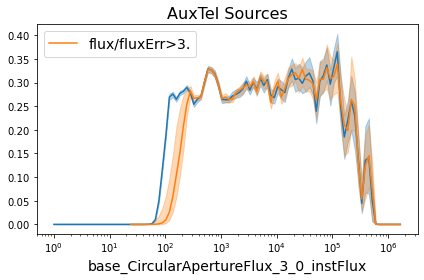

In [610]:
plot_curve(10**fvec,frac_log,ax=plt)
plot_curve(10**fvec,frac_log_mask,ax=plt,label='flux/fluxErr>3.')
plt.xscale('log')
# plt.axhline(1)
plt.legend(fontsize=14)
plt.xlabel('base_CircularApertureFlux_3_0_instFlux',fontsize=14)
# plt.ylabel('AuxTel Detection Rate',fontsize=16)
plt.title('AuxTel Sources',fontsize=16)
# plt.ylim(-0.05,1.1)
plt.tight_layout()

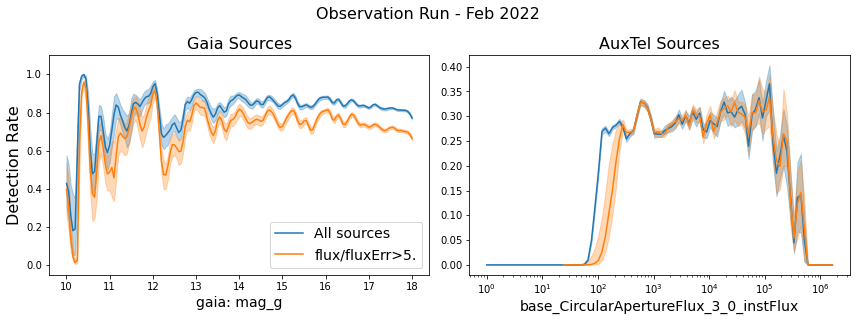

In [621]:
fig = plt.figure(figsize=(12,4.5))

plt.subplot(1, 2, 1)
plot_curve(mvec ,m_frac, label='All sources',ax=plt)
plot_curve(mvec ,m_frac_mask, label='flux/fluxErr>5.',ax=plt)
plt.legend(fontsize=14)
plt.xlabel('gaia: mag_g',fontsize=14)
plt.ylabel('Detection Rate',fontsize=16)
plt.title('Gaia Sources',fontsize=16)
#plt.tight_layout()
plt.ylim(-0.05,1.1)

plt.subplot(1, 2, 2)
plot_curve(10**fvec,frac_log,ax=plt)
plot_curve(10**fvec,frac_log_mask,ax=plt)
plt.xscale('log')
# plt.axhline(1)
# plt.legend(fontsize=14)
plt.xlabel('base_CircularApertureFlux_3_0_instFlux',fontsize=14)
# plt.ylabel('AuxTel Detection Rate',fontsize=16)
plt.title('AuxTel Sources',fontsize=16)
# plt.ylim(-0.05,1.1)
# plt.tight_layout()

fig.suptitle(f'Observation Run - Feb 2022',fontsize=16)
fig.tight_layout()
plt.savefig('auxtel_detection_rate_preliminary.png',facecolor='w',transparent=False,dpi=150)